# Earthquake Detection

In the part, we learn how to detect earthquakes from seismic waveforms. 

In [1]:
from IPython.display import Image, HTML

We use two methods:

- A traditional method STA/LTA (short-time-averaging over long-time-averaging):

[image source](https://www.mdpi.com/1424-8220/19/3/597/htm)

<!-- # Image("assets/sta-lta.jpg", width=600) -->
![](../assets/sta-lta.jpg)

- A machine learning method [PhaseNet](https://arxiv.org/abs/1803.03211):

<!-- Image("assets/phasenet.png", width=800) -->
![](../assets/phasenet.png)

In [4]:
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import numpy as np

## Download waveform using Obpsy

First, we download some seismic waveforms of known earthquakes.

You can find earthquake information from [USGS](https://earthquake.usgs.gov/earthquakes/map/?currentFeatureId=nc73753046&extent=36.63316,-128.27637&extent=42.74701,-118.69629&range=month&settings=true)
More information can be reviewed from the [Obspy](https://ai4eps.github.io/PyEarth/obspy/seismic_waveform/) section.

Here we look at a few earthquakes occurred at the Mendocino Triple Junction zone:

<!-- # Image("assets/mendocino.png", width=600) -->
![](../assets/mendocino.png)

We can pick one raspberry shake from the [station view](https://stationview.raspberryshake.org/#/?lat=40.44466&lon=-123.76179&zoom=7.484&net=AM&sta=R5E62) website.

<!-- # Image("assets/shakenet.png", width=600) -->
![](../assets/shakenet.png)

Then we can download the seismic waveforms around the earthquake origin time:

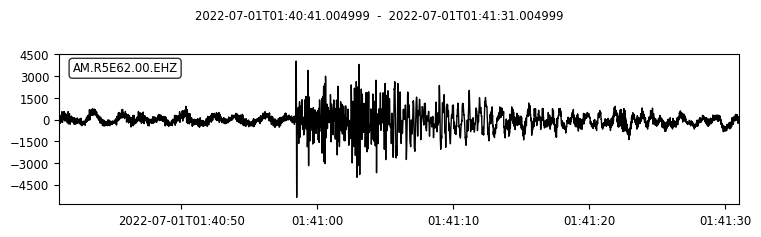

In [7]:
client = Client("RASPISHAKE")

# starttime = "2022-06-18 11:43:09"
starttime = "2022-07-01 01:40:51"
# starttime = "2022-07-05 07:21:12"
starttime = UTCDateTime(starttime) - 10
window_length = 50
waveforms = client.get_waveforms(network="AM",
                                 station="R5E62",
                                 location="*",
                                 channel="EHZ", 
                                 # starttime=UTCDateTime("2022-06-29T14:08:04"), 
                                 # endtime=UTCDateTime("2022-06-29T14:08:04")+120)  
                                 starttime=starttime, 
                                 endtime=starttime+window_length)  
waveforms = waveforms.detrend()
waveforms[0].plot();

## Detect earthquakes using STA/LTA

Detailed information can be found in the [Trigger/Picker Tutorial](https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html) of Obspy

In [8]:
from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import plot_trigger, trigger_onset

Apply the [*classic_sta_lta*](https://docs.obspy.org/packages/autogen/obspy.signal.trigger.classic_sta_lta.html) function to the downloaded waveform

In [9]:
tr = waveforms[0]
cft = classic_sta_lta(tr.data, int(5 * tr.stats.sampling_rate), int(10 * tr.stats.sampling_rate))
on_of = trigger_onset(cft, 1.5, 0.5)

Visualize the waveform and corresponding characteristic function of STA/LTA:

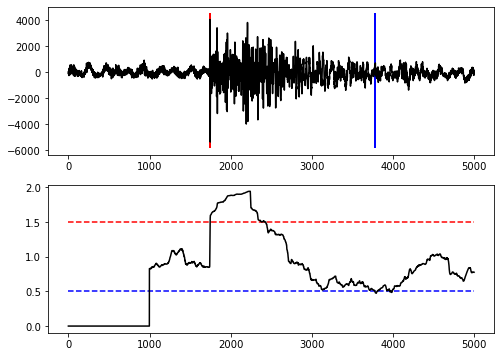

In [10]:
fig, axes = plt.subplots(2,1, figsize=(8,6))
axes[0].plot(tr.data, "k")
ymin, ymax = axes[0].get_ylim()
if len(on_of) > 0:
    axes[0].vlines(on_of[:, 0], ymin, ymax, color='r', linewidth=2)
    axes[0].vlines(on_of[:, 1], ymin, ymax, color='b', linewidth=2)
axes[1].plot(cft, 'k')
axes[1].hlines([1.5, 0.5], 0, len(cft), color=['r', 'b'], linestyle='--')
plt.show()

## Detect earthquakes using PhaseNet

We can call the PhaseNet API of the [QuakeFlow](https://github.com/wayneweiqiang/QuakeFlow) project for this test.

In [11]:
import requests
PHASENET_API_URL = "http://phasenet.quakeflow.com"

Convert the downloaded waveform into the required data format:

In [12]:
data = []
data.append(np.zeros_like(waveforms[0].data))
data.append(np.zeros_like(waveforms[0].data))
for trace in waveforms[0:1]:
    data.append(trace.data)
data = np.array(data).T
# print(data.shape)

data_id = waveforms[0].get_id()[:-1]
timestamp = waveforms[0].stats.starttime.datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]

req = {"id": [data_id],
       "timestamp": [timestamp],
       "vec": [data.tolist()]}

Get the prediction of PhaseNet and visualize the results:

<Response [200]>
Picks [{'id': 'AM.R5E62.00.EH', 'timestamp': '2022-07-01T01:40:58.434', 'prob': 0.4440344572067261, 'amp': 5381.1312, 'type': 'p'}]


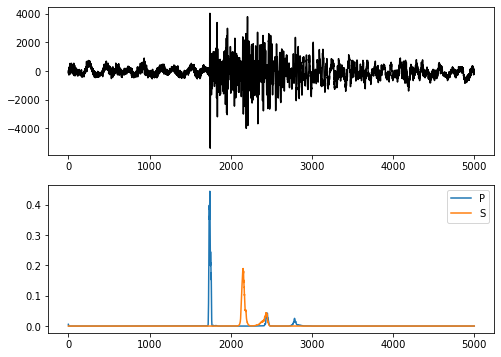

In [13]:
resp = requests.post(f'{PHASENET_API_URL}/predict_prob', json=req)
print(resp)
picks, preds = resp.json() 
preds = np.array(preds)
print('Picks', picks)

fig, axes = plt.subplots(2,1, figsize=(8,6))
axes[0].plot(data[:,-1], 'k', label="Z")
axes[1].plot(preds[0, :, 0, 1], label="P")
axes[1].plot(preds[0, :, 0, 2], label="S")
axes[1].legend()
plt.show();

## Detecting earthquakes from continuous data

In the above examples, the earthquakes are detected by USGS, so we can get the a short window of waveforms based on the detected earthquake origin time.

In this example, we will detect earthquake signals from raw continuous data and see if we can also find these earthquakes without the USGS catalog.

For example, we can download one days' data using Obspy and detect the earthquakes in it.

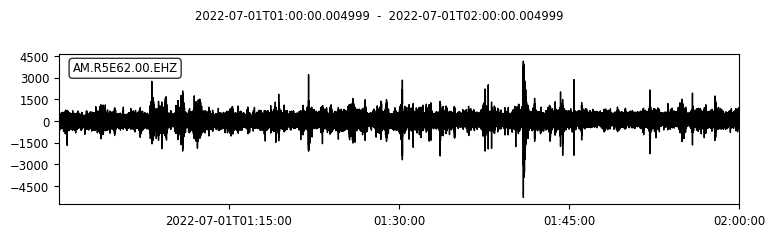

/Users/weiqiang/.local/miniconda3/lib/python3.8/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [14]:
client = Client("RASPISHAKE")

starttime = UTCDateTime("2022-07-01 01:00:00")
endtime = UTCDateTime("2022-07-01 02:00:00")
waveforms = client.get_waveforms(network="AM",
                                 station="R5E62",
                                 location="*",
                                 channel="EHZ", 
                                 starttime=starttime, 
                                 endtime=endtime)  
waveforms = waveforms.detrend()
waveforms = waveforms.merge(fill_value=0)
waveforms[0].plot();
waveforms.write("one-hour.mseed")

We save the mseed data to avoid repeatedly download the continuous waveform. 

In [15]:
waveforms = obspy.read("one-hour.mseed")

- First, we apply the STA/LTA method to find earthquakes in the one-hour waveform

In [16]:
tr = waveforms[0]
cft = classic_sta_lta(tr.data, int(1 * tr.stats.sampling_rate), int(5 * tr.stats.sampling_rate))
on_of = trigger_onset(cft, 3.5, 1.0, max_len=1000)
print(f"Number of detected earthquakes: {len(on_of)}")

Number of detected earthquakes: 7


We can visualize the waveforms of these detected events. 

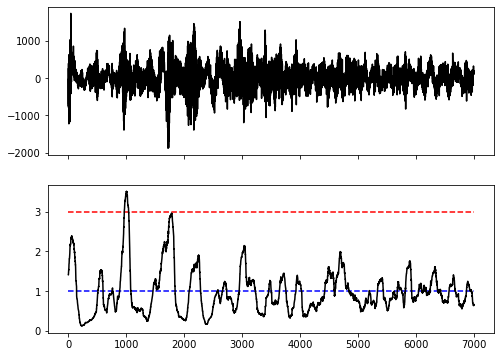

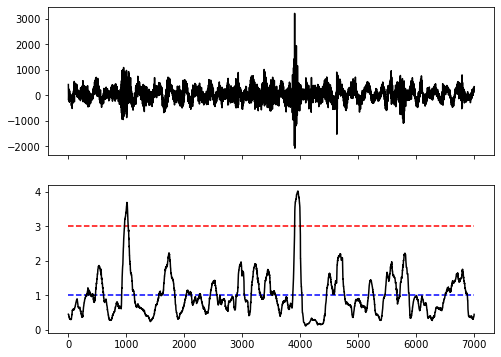

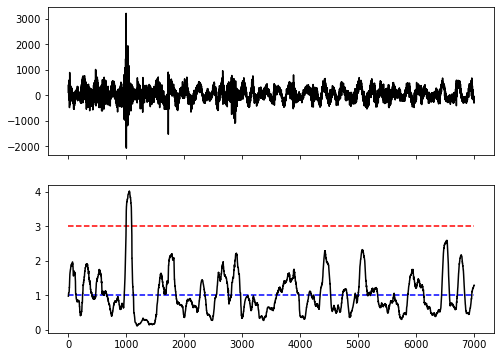

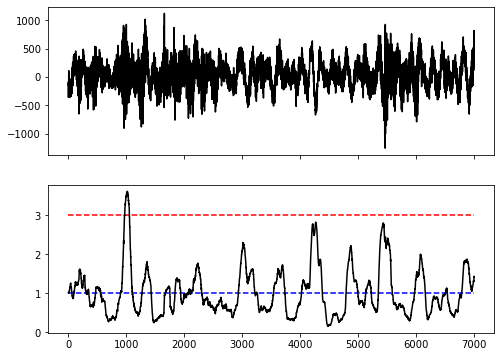

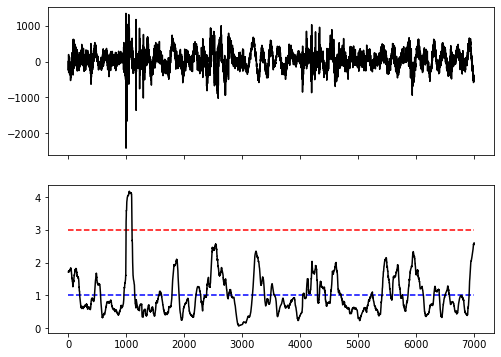

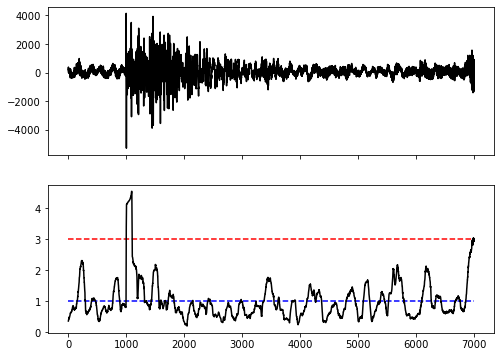

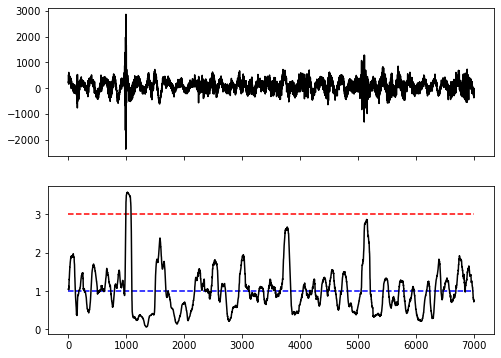

In [17]:
for (t0, tn) in on_of:
    t0 = t0 - 1000
    tn = t0 + 7000
    fig, axes = plt.subplots(2,1, figsize=(8,6), sharex=True)
    axes[0].plot(tr.data[t0:tn], "k")
    ymin, ymax = axes[0].get_ylim()
    if len(on_of) > 0:
        axes[0].vlines(on_of[t0:tn, 0], ymin, ymax, color='r', linewidth=2)
        axes[0].vlines(on_of[t0:tn, 1], ymin, ymax, color='b', linewidth=2)
    axes[1].plot(cft[t0:tn], 'k')
    axes[1].hlines([3.0, 1.0], 0, len(cft[t0:tn]), color=['r', 'b'], linestyle='--')
    plt.show()
    # break

Q: Are these detected signals true earthquakes? 

- Second, we apply PhaseNet to detect earthquakes of the same dataset

No event between 2022-07-01T01:00:00.000000Z and 2022-07-01T01:02:30.000000Z
No event between 2022-07-01T01:02:30.000000Z and 2022-07-01T01:05:00.000000Z
No event between 2022-07-01T01:05:00.000000Z and 2022-07-01T01:07:30.000000Z
No event between 2022-07-01T01:07:30.000000Z and 2022-07-01T01:10:00.000000Z
No event between 2022-07-01T01:10:00.000000Z and 2022-07-01T01:12:30.000000Z
No event between 2022-07-01T01:12:30.000000Z and 2022-07-01T01:15:00.000000Z
No event between 2022-07-01T01:15:00.000000Z and 2022-07-01T01:17:30.000000Z
No event between 2022-07-01T01:17:30.000000Z and 2022-07-01T01:20:00.000000Z
No event between 2022-07-01T01:20:00.000000Z and 2022-07-01T01:22:30.000000Z
No event between 2022-07-01T01:22:30.000000Z and 2022-07-01T01:25:00.000000Z
No event between 2022-07-01T01:25:00.000000Z and 2022-07-01T01:27:30.000000Z
No event between 2022-07-01T01:27:30.000000Z and 2022-07-01T01:30:00.000000Z
No event between 2022-07-01T01:30:00.000000Z and 2022-07-01T01:32:30.000000Z

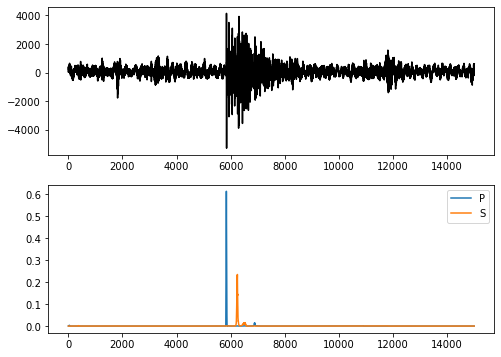

No event between 2022-07-01T01:42:30.000000Z and 2022-07-01T01:45:00.000000Z
No event between 2022-07-01T01:45:00.000000Z and 2022-07-01T01:47:30.000000Z
No event between 2022-07-01T01:47:30.000000Z and 2022-07-01T01:50:00.000000Z
No event between 2022-07-01T01:50:00.000000Z and 2022-07-01T01:52:30.000000Z
No event between 2022-07-01T01:52:30.000000Z and 2022-07-01T01:55:00.000000Z
No event between 2022-07-01T01:55:00.000000Z and 2022-07-01T01:57:30.000000Z
No event between 2022-07-01T01:57:30.000000Z and 2022-07-01T02:00:00.000000Z


In [18]:
data = []
data.append(np.zeros_like(waveforms[0].data))
data.append(np.zeros_like(waveforms[0].data))
for trace in waveforms[0:1]:
    data.append(trace.data)
data = np.array(data).T
data = data.astype("float32")
# print(data.shape)

window_length = int(6000*2.5)
for i in range(0, len(data) - window_length, window_length):
    data_id = waveforms[0].get_id()[:-1]
    timestamp = (starttime + i/100.0).datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]

    req = {"id": [data_id],
           "timestamp": [timestamp],
           "vec": [data[i:i+window_length].tolist()]}

    resp = requests.post(f'{PHASENET_API_URL}/predict_prob', json=req)
    # print(resp)
    picks, preds = resp.json() 
    preds = np.array(preds)
    if len(picks) > 0:
        print('Picks', picks)
        fig, axes = plt.subplots(2,1, figsize=(8,6))
        axes[0].plot(data[i:i+window_length,-1], 'k', label="Z")
        axes[1].plot(preds[0, :, 0, 1], label="P")
        axes[1].plot(preds[0, :, 0, 2], label="S")
        axes[1].legend()
        plt.show();
    else:
        print(f"No event between {starttime+i/100.0} and {starttime+i/100.0+window_length/100.0}")

Q1: Is the detected event information same as the first example above?

Q2: How do PhaseNet results compared with STA/LTA?

## Detecting volcanic earthquakes

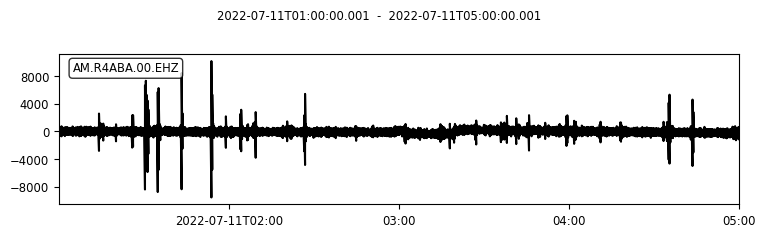

/Users/weiqiang/.local/miniconda3/lib/python3.8/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [19]:
starttime = UTCDateTime("2022-07-11 01:00:00")
endtime = UTCDateTime("2022-07-11 05:00:00")
waveforms = client.get_waveforms(network="AM",
                                 station="R4ABA",
                                 location="*",
                                 channel="EHZ", 
                                 starttime=starttime, 
                                 endtime=endtime)  
waveforms = waveforms.detrend()
waveforms = waveforms.merge(fill_value=0)
waveforms[0].plot();
waveforms.write("one-hour.mseed")

No event between 2022-07-11T01:00:00.000000Z and 2022-07-11T01:02:30.000000Z
Picks [{'id': 'AM.R4ABA.00.EH', 'timestamp': '2022-07-11T01:03:19.440', 'prob': 0.5183876752853394, 'amp': 520.11572265625, 'type': 'p'}]


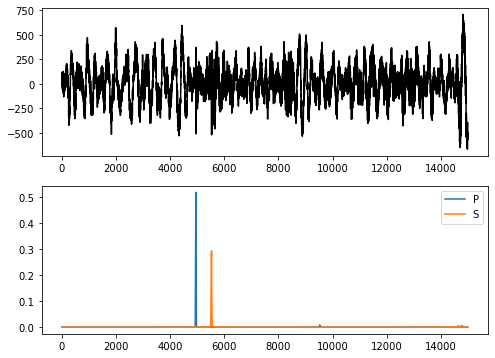

No event between 2022-07-11T01:05:00.000000Z and 2022-07-11T01:07:30.000000Z
No event between 2022-07-11T01:07:30.000000Z and 2022-07-11T01:10:00.000000Z
No event between 2022-07-11T01:10:00.000000Z and 2022-07-11T01:12:30.000000Z
Picks [{'id': 'AM.R4ABA.00.EH', 'timestamp': '2022-07-11T01:14:14.760', 'prob': 0.5133991837501526, 'amp': 2834.1376953125, 'type': 'p'}, {'id': 'AM.R4ABA.00.EH', 'timestamp': '2022-07-11T01:14:20.230', 'prob': 0.3006688356399536, 'amp': 2575.741455078125, 'type': 's'}]


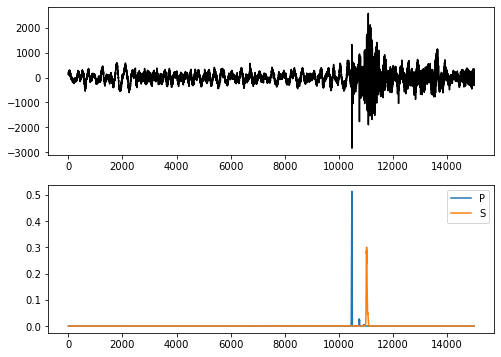

No event between 2022-07-11T01:15:00.000000Z and 2022-07-11T01:17:30.000000Z
No event between 2022-07-11T01:17:30.000000Z and 2022-07-11T01:20:00.000000Z
Picks [{'id': 'AM.R4ABA.00.EH', 'timestamp': '2022-07-11T01:20:11.600', 'prob': 0.7828038930892944, 'amp': 1446.291748046875, 'type': 'p'}, {'id': 'AM.R4ABA.00.EH', 'timestamp': '2022-07-11T01:20:17.280', 'prob': 0.6105919480323792, 'amp': 977.4058837890625, 'type': 's'}]


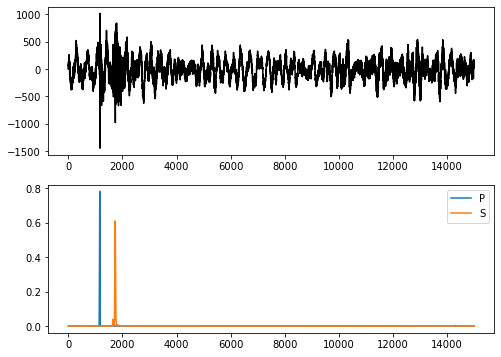

No event between 2022-07-11T01:22:30.000000Z and 2022-07-11T01:25:00.000000Z
No event between 2022-07-11T01:25:00.000000Z and 2022-07-11T01:27:30.000000Z
No event between 2022-07-11T01:27:30.000000Z and 2022-07-11T01:30:00.000000Z
Picks [{'id': 'AM.R4ABA.00.EH', 'timestamp': '2022-07-11T01:30:31.600', 'prob': 0.5890001058578491, 'amp': 8428.8212890625, 'type': 'p'}]


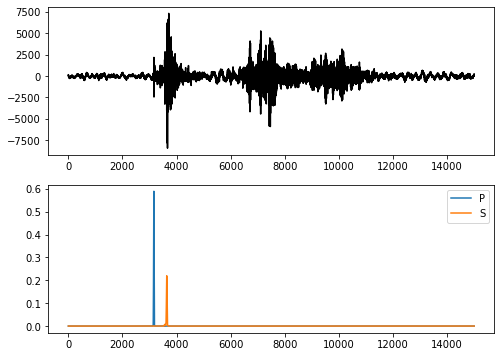

No event between 2022-07-11T01:32:30.000000Z and 2022-07-11T01:35:00.000000Z
No event between 2022-07-11T01:35:00.000000Z and 2022-07-11T01:37:30.000000Z
No event between 2022-07-11T01:37:30.000000Z and 2022-07-11T01:40:00.000000Z
No event between 2022-07-11T01:40:00.000000Z and 2022-07-11T01:42:30.000000Z
No event between 2022-07-11T01:42:30.000000Z and 2022-07-11T01:45:00.000000Z
No event between 2022-07-11T01:45:00.000000Z and 2022-07-11T01:47:30.000000Z
No event between 2022-07-11T01:47:30.000000Z and 2022-07-11T01:50:00.000000Z
No event between 2022-07-11T01:50:00.000000Z and 2022-07-11T01:52:30.000000Z
No event between 2022-07-11T01:52:30.000000Z and 2022-07-11T01:55:00.000000Z
No event between 2022-07-11T01:55:00.000000Z and 2022-07-11T01:57:30.000000Z
No event between 2022-07-11T01:57:30.000000Z and 2022-07-11T02:00:00.000000Z
No event between 2022-07-11T02:00:00.000000Z and 2022-07-11T02:02:30.000000Z
No event between 2022-07-11T02:02:30.000000Z and 2022-07-11T02:05:00.000000Z

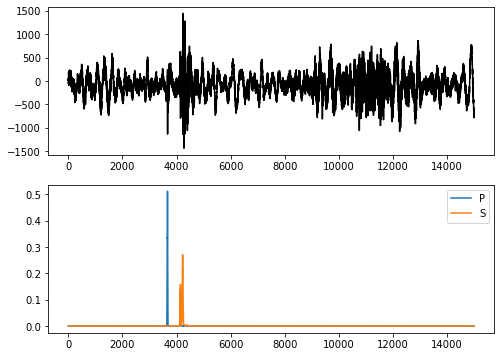

No event between 2022-07-11T02:22:30.000000Z and 2022-07-11T02:25:00.000000Z
No event between 2022-07-11T02:25:00.000000Z and 2022-07-11T02:27:30.000000Z
No event between 2022-07-11T02:27:30.000000Z and 2022-07-11T02:30:00.000000Z
No event between 2022-07-11T02:30:00.000000Z and 2022-07-11T02:32:30.000000Z
No event between 2022-07-11T02:32:30.000000Z and 2022-07-11T02:35:00.000000Z
No event between 2022-07-11T02:35:00.000000Z and 2022-07-11T02:37:30.000000Z
No event between 2022-07-11T02:37:30.000000Z and 2022-07-11T02:40:00.000000Z
No event between 2022-07-11T02:40:00.000000Z and 2022-07-11T02:42:30.000000Z
No event between 2022-07-11T02:42:30.000000Z and 2022-07-11T02:45:00.000000Z
No event between 2022-07-11T02:45:00.000000Z and 2022-07-11T02:47:30.000000Z
No event between 2022-07-11T02:47:30.000000Z and 2022-07-11T02:50:00.000000Z
No event between 2022-07-11T02:50:00.000000Z and 2022-07-11T02:52:30.000000Z
No event between 2022-07-11T02:52:30.000000Z and 2022-07-11T02:55:00.000000Z

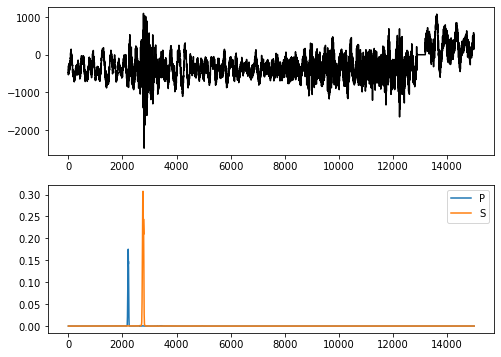

No event between 2022-07-11T03:20:00.000000Z and 2022-07-11T03:22:30.000000Z
No event between 2022-07-11T03:22:30.000000Z and 2022-07-11T03:25:00.000000Z
No event between 2022-07-11T03:25:00.000000Z and 2022-07-11T03:27:30.000000Z
No event between 2022-07-11T03:27:30.000000Z and 2022-07-11T03:30:00.000000Z
No event between 2022-07-11T03:30:00.000000Z and 2022-07-11T03:32:30.000000Z
No event between 2022-07-11T03:32:30.000000Z and 2022-07-11T03:35:00.000000Z
No event between 2022-07-11T03:35:00.000000Z and 2022-07-11T03:37:30.000000Z
No event between 2022-07-11T03:37:30.000000Z and 2022-07-11T03:40:00.000000Z
No event between 2022-07-11T03:40:00.000000Z and 2022-07-11T03:42:30.000000Z
No event between 2022-07-11T03:42:30.000000Z and 2022-07-11T03:45:00.000000Z
Picks [{'id': 'AM.R4ABA.00.EH', 'timestamp': '2022-07-11T03:45:49.580', 'prob': 0.305012047290802, 'amp': 2783.478759765625, 'type': 'p'}]


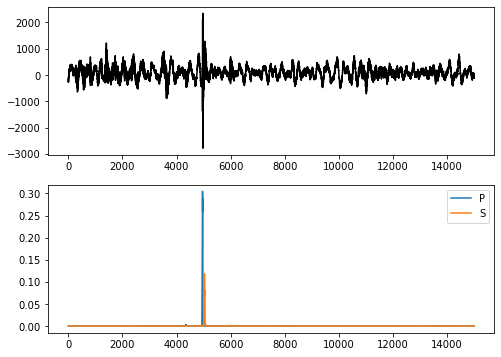

No event between 2022-07-11T03:47:30.000000Z and 2022-07-11T03:50:00.000000Z
Picks [{'id': 'AM.R4ABA.00.EH', 'timestamp': '2022-07-11T03:51:31.590', 'prob': 0.4973580539226532, 'amp': 1238.3836669921875, 'type': 's'}]


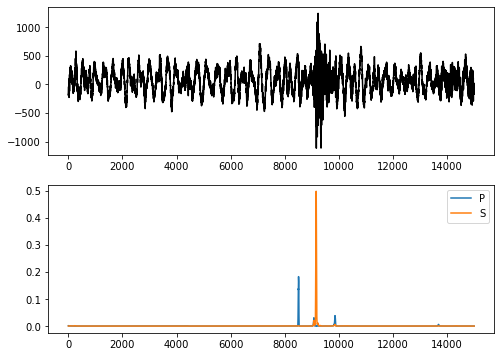

No event between 2022-07-11T03:52:30.000000Z and 2022-07-11T03:55:00.000000Z
No event between 2022-07-11T03:55:00.000000Z and 2022-07-11T03:57:30.000000Z
No event between 2022-07-11T03:57:30.000000Z and 2022-07-11T04:00:00.000000Z
No event between 2022-07-11T04:00:00.000000Z and 2022-07-11T04:02:30.000000Z
No event between 2022-07-11T04:02:30.000000Z and 2022-07-11T04:05:00.000000Z
No event between 2022-07-11T04:05:00.000000Z and 2022-07-11T04:07:30.000000Z
No event between 2022-07-11T04:07:30.000000Z and 2022-07-11T04:10:00.000000Z
No event between 2022-07-11T04:10:00.000000Z and 2022-07-11T04:12:30.000000Z
No event between 2022-07-11T04:12:30.000000Z and 2022-07-11T04:15:00.000000Z
No event between 2022-07-11T04:15:00.000000Z and 2022-07-11T04:17:30.000000Z
No event between 2022-07-11T04:17:30.000000Z and 2022-07-11T04:20:00.000000Z
No event between 2022-07-11T04:20:00.000000Z and 2022-07-11T04:22:30.000000Z
No event between 2022-07-11T04:22:30.000000Z and 2022-07-11T04:25:00.000000Z

In [20]:
data = []
data.append(np.zeros_like(waveforms[0].data))
data.append(np.zeros_like(waveforms[0].data))
for trace in waveforms[0:1]:
    data.append(trace.data)
data = np.array(data).T
data = data.astype("float32")
# print(data.shape)

window_length = int(6000*2.5)
for i in range(0, len(data) - window_length, window_length):
    data_id = waveforms[0].get_id()[:-1]
    timestamp = (starttime + i/100.0).datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]

    req = {"id": [data_id],
           "timestamp": [timestamp],
           "vec": [data[i:i+window_length].tolist()]}

    resp = requests.post(f'{PHASENET_API_URL}/predict_prob', json=req)
    # print(resp)
    picks, preds = resp.json() 
    preds = np.array(preds)
    if len(picks) > 0:
        print('Picks', picks)
        fig, axes = plt.subplots(2,1, figsize=(8,6))
        axes[0].plot(data[i:i+window_length,-1], 'k', label="Z")
        axes[1].plot(preds[0, :, 0, 1], label="P")
        axes[1].plot(preds[0, :, 0, 2], label="S")
        axes[1].legend()
        plt.show();
    else:
        print(f"No event between {starttime+i/100.0} and {starttime+i/100.0+window_length/100.0}")